In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Reshape, Flatten, Lambda, Conv2DTranspose
from keras.preprocessing import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# download training and test data from mnist and reshape it

from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_test = X_test.astype('float32') / 255.
X_test = X_test.reshape(-1,28,28,1)
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
# Create encoder network

latent_dim = 2 # dimension of latent variable

inputs = Input(shape = (28,28,1))
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(inputs)
conv1_1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(conv1)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1_1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)

flat = Flatten()(pool2)
input_to_z = Dense(32, activation = 'relu')(flat)
mu = Dense(latent_dim, name='mu')(input_to_z)
sigma = Dense(latent_dim, name='log_var')(input_to_z)

encoder = Model(inputs, mu)

In [5]:
# create latent distribution function and generate vectors

def sampling(args):
    mu, sigma = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return mu + K.exp(sigma) * epsilon

z = Lambda(sampling)([mu, sigma])

In [6]:
#create decoder network which is reverse of encoder

decoder_inputs = Input(K.int_shape(z)[1:])
dense_layer_d = Dense(7*7*32, activation = 'relu')(decoder_inputs)
output_from_z_d = Reshape((7,7,32))(dense_layer_d)
trans1_d = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(output_from_z_d)
trans1_1_d = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(trans1_d)
trans2_d = Conv2DTranspose(1, 3, padding='same', activation='relu')(trans1_1_d)


decoder = Model(decoder_inputs, trans2_d)
z_decoded = decoder(z)

In [7]:
#calculate reconstruction loss and KL divergence

class calc_output_with_los(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

outputs = calc_output_with_los()([inputs, z_decoded])

In [8]:
# define variational autoencoder model and train it

vae = Model(inputs, outputs)
m = 256
n_epoch = 10
vae.compile(optimizer='adam', loss=None)
vae.fit(X_train, epochs=n_epoch, batch_size=m, shuffle=True, validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 407us/step - loss: 0.3179 - val_loss: 0.2512
Epoch 2/10
60000/60000 [==============================] - 12s 206us/step - loss: 0.2426 - val_loss: 0.2384
Epoch 3/10
60000/60000 [==============================] - 12s 207us/step - loss: 0.2329 - val_loss: 0.2286
Epoch 4/10
60000/60000 [==============================] - 12s 207us/step - loss: 0.2251 - val_loss: 0.2226
Epoch 5/10
60000/60000 [==============================] - 12s 208us/step - loss: 0.2209 - val_loss: 0.2158
Epoch 6/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.2136 - val_loss: 0.2114
Epoch 7/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.2169 - val_loss: 0.2151
Epoch 8/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.2098 - val_loss: 0.2075
Epoch 9/10
60000/60000 [==============================] - 12s 206us/step - loss: 0.2088 - val_

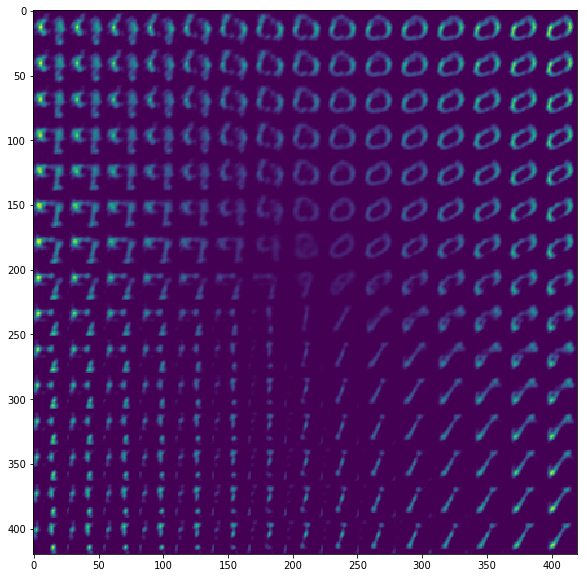

In [9]:
n = 15  # figure with 15x15 digits

digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1.
        x_decoded = decoder.predict(z_sample)
#         print(x_decoded)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show() 